In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm

/home/asuka/anaconda3/envs/py3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# helper funcs
def plot_helper_2d(xy_list):
    xs = [x[0] for x in xy_list]
    ys = [x[1] for x in xy_list]
    plt.plot(xs, ys, 'x')
    plt.show()


def plot_helper_1d(x_list):
    plt.plot(x_list, np.zeros(len(x_list)), 'x')
    plt.show()


def gaussian_sampler(mean, cov, num_samples):
    return np.random.multivariate_normal(mean, cov, num_samples)


def projection(x, w):
    return x[0]*w[0] + x[1]*w[1]


def batch_projection(xs, w):
    return torch.sum(xs * w, dim=1)


def rotate(w, angle):
    A = np.array(w)
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    A = np.dot(R, A)
    return A


def get_ws(num_ws=360):
    w0 = [1, 0]
    ws = []
    for i in range(num_ws):
        cur_angle = 360 / num_ws * i
        ws.append(rotate(w0, cur_angle))
    return ws

In [3]:
# train model
def get_batch_size_samples(batch_size, sample_data, seed=0):
    np.random.seed(seed=seed)
    np.random.shuffle(sample_data)
    batch_samples = []
    for i in range(int(len(sample_data)/batch_size)):
        batch_samples.append(sample_data[i*batch_size:(i+1)*batch_size])
    return batch_samples


def get_batch_size_inputs(num_batches, batch_size, seed=0):
    np.random.seed(seed=seed)
    batch_inputs = []
    all_inputs = np.random.rand(num_batches, batch_size)
    for i in range(num_batches):
        batch_inputs.append(all_inputs[i, :])
    return batch_inputs


def prepare_batch(batch_size, sample_data):
    batch_samples = get_batch_size_samples(batch_size, sample_data)
    num_batches = len(batch_samples)
    batch_inputs = get_batch_size_inputs(num_batches, batch_size)
    batches = []
    for i in range(num_batches):
        current_samples = torch.tensor(batch_samples[i], dtype=torch.float32)
        current_inputs = torch.tensor(batch_inputs[i], dtype=torch.float32)
        batches.append((current_inputs, current_samples))
    return batches

In [4]:
# define model
class FF(nn.Module):
    def __init__(self, input_dim, num_layers, hidden_dim, output_dim, actv=nn.ReLU()):
        super(FF, self).__init__()
        self.fcin = nn.Linear(input_dim, hidden_dim)
        self.fcout = nn.Linear(hidden_dim, output_dim)
        fc_layers = []
        for _ in range(num_layers):   
            fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
            fc_layers.append(nn.ReLU())
        self.fcmid = nn.Sequential(*fc_layers)
        self.actv = actv

    def forward(self, x):
        x = self.actv(self.fcin(x))
        x = self.fcmid(x)
        x = self.fcout(x)
        return x

In [5]:
class Generator:
    def __init__(self, model, lr, epochs, batch_size, data, device) -> None:
        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.data = data
        self.device = device
        
    def train(self, w):
        lr = self.lr
        epochs = self.epochs
        batch_size = self.batch_size
        device = self.device
        batches = prepare_batch(batch_size, self.data)
        
        model = self.model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        for i in range(epochs):
            model.train()
            losses = []
            for batch in batches:
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                x = x[:, None]
                y_pred = model(x)
                
                # projection
                y_proj = batch_projection(y, w)
                yp_proj = batch_projection(y_pred, w)
                
                y_proj, _ = torch.sort(y_proj)
                yp_proj, _ = torch.sort(yp_proj)
                
                loss = loss_fn(y_proj, yp_proj)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1, error_if_nonfinite=True)
                optimizer.step()
                losses.append(loss.detach().cpu().numpy())
            # print(np.mean(losses))
        self.model = model
    
    def sampler(self, num_samples):
        test_samples = []
        model = self.model.to(self.device)
        model.eval()
        num_batches = int(num_samples/self.batch_size)+1
        batch_inputs = get_batch_size_inputs(num_batches, self.batch_size)
        for i in range(num_batches):
            current_inputs = torch.tensor(batch_inputs[i], dtype=torch.float32).to(self.device)
            current_inputs = current_inputs[:, None]
            y_pred = model(current_inputs)
            y_pred = y_pred.detach().cpu()
            for i in range(self.batch_size):
                test_samples.append(y_pred[i])
        return test_samples


class Discriminator:
    def __init__(self, ws, data, device) -> None:      
        self.ws = torch.tensor(ws)
        self.data = torch.tensor(data).to(device)
        self.device = device
    
    def dist_loss(self, samples, w):
        samples = torch.stack(samples, dim=0).to(self.device)
        length = min(len(self.data), len(samples))
        data = self.data[:length]
        samples = samples[:length]
        y_proj = batch_projection(data, w)
        yp_proj = batch_projection(samples, w)
        y_proj, _ = torch.sort(y_proj)
        yp_proj, _ = torch.sort(yp_proj)
        loss_fn = nn.L1Loss()
        loss = loss_fn(y_proj, yp_proj)
        return loss
    
    def next_dir(self, samples):
        max_loss = 0
        max_dir_idx = 0
        for i in range(len(self.ws)):
            loss = self.dist_loss(samples, self.ws[i])
            if loss > max_loss:
                max_loss = loss
                max_dir_idx = i
        return self.ws[max_dir_idx]

In [6]:
iterations = 20

device = torch.device("cuda")
batch_size = 512

num_samples = 50000
mean = [1, 4]
cov = [[1, 0], [0, 1]]
data = gaussian_sampler(mean, cov, num_samples)

ws = get_ws(45)
ws = torch.tensor(ws, device=device)

generator = Generator(model=FF(1, 4, 128, 2), lr=0.0001, epochs=5, batch_size=512, data=data, device=device)
discriminator = Discriminator(ws, data=data, device=device)

w_trace = []
for i in tqdm(range(iterations)):
    samples = generator.sampler(num_samples)
    w = discriminator.next_dir(samples)
    w_trace.append(w)
    generator.train(w)

/home/asuka/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541035/work/torch/csrc/utils/tensor_new.cpp:230.)
  if sys.path[0] == "":
/home/asuka/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


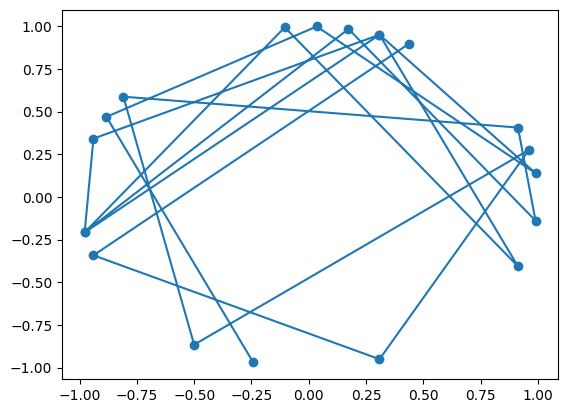

In [14]:
w1 = []
w2 = []
for i, w in enumerate(w_trace):
    w = w.cpu().numpy()
    w1.append(w[0])
    w2.append(w[1])
plt.plot(w1, w2, '-o')
plt.show()

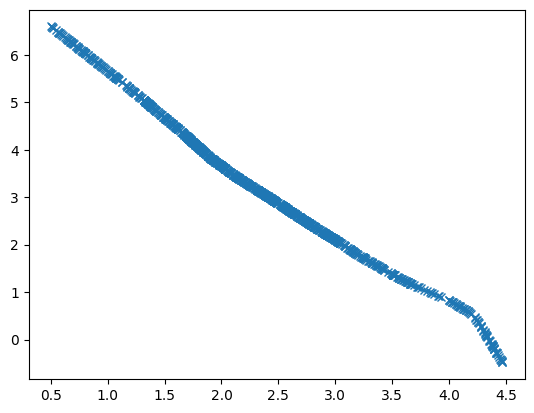

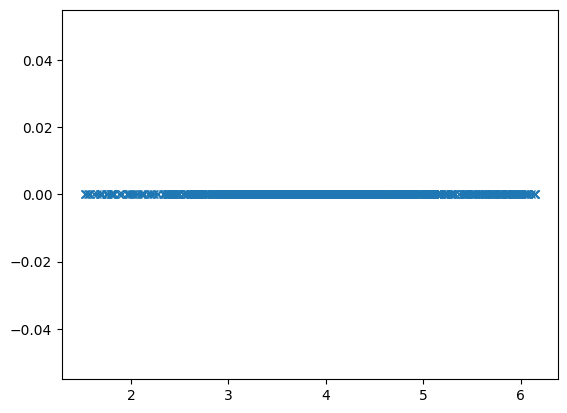

(array([ 4.,  2.,  2.,  5.,  1.,  7.,  4.,  2.,  1.,  5.,  3.,  2.,  3.,
         1.,  3.,  2.,  2.,  3.,  8.,  9.,  8.,  3.,  5.,  6., 11., 12.,
        16.,  4., 11.,  9.,  9., 14., 10., 12.,  6., 14., 16., 19., 18.,
        14., 20., 19., 16., 19., 20., 25., 13., 27., 21., 18., 21., 16.,
        17., 23., 15., 11., 21., 19., 19., 17., 13., 14., 17., 21., 14.,
        22., 13., 10., 11., 11., 11., 13.,  9.,  6.,  8., 13., 15., 14.,
         5.,  7.,  5.,  8.,  1.,  6.,  9.,  6.,  4.,  4.,  7.,  6.,  7.,
         7.,  7.,  6.,  5.,  8.,  5.,  4.,  5.,  4.]),
 array([1.523204 , 1.5694937, 1.6157835, 1.6620731, 1.7083629, 1.7546526,
        1.8009424, 1.8472321, 1.8935219, 1.9398116, 1.9861014, 2.032391 ,
        2.0786808, 2.1249707, 2.1712604, 2.21755  , 2.2638397, 2.3101294,
        2.3564193, 2.402709 , 2.4489987, 2.4952884, 2.5415783, 2.587868 ,
        2.6341577, 2.6804473, 2.7267373, 2.773027 , 2.8193166, 2.8656063,
        2.9118962, 2.958186 , 3.0044756, 3.0507653, 3.097055 , 3

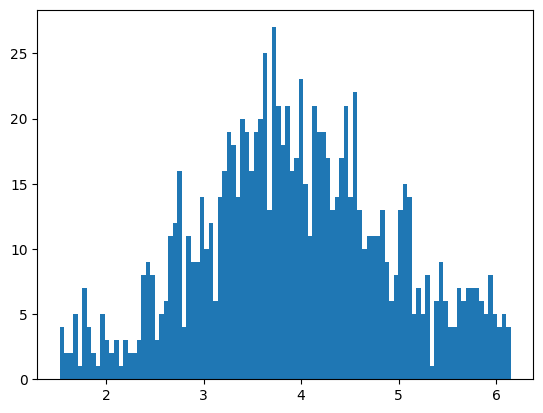

In [16]:
samples = generator.sampler(1000)
plot_helper_2d(samples)
w = w_trace[-1]
w = w.cpu().numpy()
data_1d = [projection(x, w) for x in samples]
plot_helper_1d(data_1d)
plt.hist(data_1d, bins=100, log=False)
